In [5]:
!pip install opencv-python
import numpy as np
from matplotlib import pyplot as plt
import pdb
import cv2
import glob

You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
# a 2D example
class PerceptronExample:
    def __init__(self, limit=50):
        # the decision boundary is y = np.dot(self.w, x)
        self.w = np.array([0, 0], dtype=np.float64)
        self.pts = None
        self.labels = None
        self.limit = limit
        self.x = np.linspace(-self.limit, self.limit)
        
    
    def add_pts(self, pt, label):
        if self.pts is None:
            self.pts = np.array(pt).reshape(1,2)
        else:
            self.pts = np.append(self.pts, np.array(pt).reshape(1,2), axis=0)
        if self.labels is None:
            self.labels = np.array([label])
        else:
            self.labels = np.append(self.labels, label)
        
        
    def reset_pts(self):
        self.pts = None
        self.labels = None
        
        
    def plot(self):
        ax = plt.gca()
        ax.set_xlim(-self.limit, self.limit)
        ax.set_ylim(-self.limit, self.limit)
        self.plot_pts()
        self.plot_decision_boundary()
        plt.show()
        
    def plot_pts(self):
        for i in range(len(self.pts)):
            if self.labels[i] == 1:
                plt.plot(self.pts[i, 0], self.pts[i, 1], 'ro')
            else:
                plt.plot(self.pts[i, 0], self.pts[i, 1], 'bx')
        
                
    def plot_decision_boundary(self):
        if self.w[1] == 0:
            y = np.zeros_like(self.x)
        else:
            y = -(self.x * self.w[0]) / self.w[1]
        plt.plot(self.x, y)
        plt.fill_between(self.x, y, self.limit, alpha=0.7)
        
        
    def update(self):
        all_done = True
        for i in range(len(self.pts)):
            if np.dot(self.pts[i], self.w) * self.labels[i] <= 0:
                self.w += self.pts[i] * self.labels[i]
                all_done = False
                break
        return all_done

In [ ]:
import ipywidgets as widgets
from IPython.display import display
limit = 50
x1 = widgets.BoundedFloatText(10.0, description='x1: ', min=-limit, max=limit)
x2 = widgets.BoundedFloatText(30.0, description='x2: ', min=-limit, max=limit)
label = widgets.RadioButtons(
    options=['-1', '1'],
    description='label:',
    disabled=False
)
add = widgets.Button(
    description='add a point',
    disabled=False,
    button_style='',
)
reset = widgets.Button(
    description='reset points',
    disabled=False,
    button_style='',
)
plot = widgets.Button(
    description='plot',
    disabled=False,
    button_style='',
)
update = widgets.Button(
    description='update',
    disabled=False,
    button_style='',
)
out = widgets.Button(
    description='print weight',
    disabled=False,
    button_style='',
)


ex = PerceptronExample()

def add_callback(event):
    ex.add_pts((x1.value, x2.value), float(label.value))
    
def reset_callback(event):
    ex.reset_pts()
    
def plot_callback(event):
    ex.plot()

def update_callback(event):
    done = ex.update()
    print('Done: ', done)

def out_callback(event):
    print('weight: ', ex.w)
    
add.on_click(add_callback)
reset.on_click(reset_callback)
plot.on_click(plot_callback)
update.on_click(update_callback)
out.on_click(out_callback)
display(x1, x2, label)
display(add, reset, plot, update, out)

## Interpretation of the perceptron update rules
The updata rule for perceptron is 
> (misclassified the example (x_i, y_i) using the weight w)
> 
> if $y_i * (w x_i ) \leq 0$:   
>    $w = w + y_i x_i$
> 


When we start with w = 0, at the end w becomes
$$
w = \sum_i \alpha_i y_i x_i
$$
a weighted sum of $y_i x_i$. 


### quiz: 
argue that the weight must have the form $$w = \sum_i \alpha_i y_i x_i$$

If we plug $w = \sum_i \alpha_i y_i x_i$ back to the update rule, now we have

>if $y_i * (\sum_j \alpha_j y_j x_j x_i ) \leq 0$:   
>    $\alpha_i = \alpha_i + 1$

Notice
$$
y_i * (\sum_j \alpha_j y_j x_j x_i ) = \sum_j \alpha_j \langle y_jx_j, y_ix_i \rangle
$$
So we are finding a set of weights $\alpha_j$ for inner product pair $\langle y_jx_j, y_ix_i \rangle$ so that for all data point $(x_i, y_i)$,
$$
\sum_j \alpha_j \langle y_jx_j, y_ix_i \rangle > 0
$$
If we find this doesn't hold true for $(x_i, y_i)$ yet, we add 1 to $\alpha_i$.


### quiz:
By adding 1 to $\alpha_i$, what happens to the sum $\sum_j \alpha_j \langle y_jx_j, y_ix_i \rangle$? Does that makes sense?

This makes sense since $\langle y_ix_i, y_ix_i \rangle > 0$. When we do $\alpha_i = \alpha_i + 1$, we add a positve number $\langle y_ix_i, y_ix_i \rangle$ to the sum $\sum_j \alpha_j \langle y_jx_j, y_ix_i \rangle$. So after serveral times, this sum becomes positive and we can stop.

## Training perceptron on Emoji data 

In [1]:
def visualize_results(images, preds, labels, alpha):
    num_samples = images.shape[0]
    fig, axes = plt.subplots(1, num_samples)
    items = sorted([[index, value] for index, value in enumerate(preds)], key=lambda x:x[1])
    sorted_idx = [item[0] for item in items]
    images = images[sorted_idx]
    labels = labels[sorted_idx]
    alpha  = alpha[sorted_idx]
    for i in range(images.shape[0]):
        axes[i].axis('off')
        axes[i].set_title('{}'.format(alpha[i][0]), fontdict={'fontsize':30})
        image = images[i].copy()
        if labels[i] == 1:
            image = image[...,::-1]
        axes[i].imshow(image)
    plt.show()

def load_image(file_names, size=(20, 20)):
    img_arr, lab_arr, reduced = [], [], []
    for file_name in file_names:
        _, name_type, name = file_name.split('/')
        img, lab = cv2.imread(file_name), -1
        reduced.append(cv2.resize(img, size, interpolation = cv2.INTER_CUBIC))
        if name_type == 'train_smile': 
            lab = 1
        img_arr.append(img)
        lab_arr.append(lab)
    return np.stack(reduced), np.stack(img_arr), np.stack(lab_arr)[...,None]

def test_on_emoji_dataset(p_class):
    file_names = glob.glob('data/*/*.*')
    reduced, images, labels = load_image(file_names)
    p = p_class(reduced.reshape(reduced.shape[0], -1), labels)
    for i in range(100): 
        p.update()
        preds, y_hat = p.predict()
        visualize_results(images, preds, labels, p.alpha)

In [10]:
class DualPerceptron(object):

    def __init__(self, x, y, alpha = None):
        self.x, self.y = x, y
        if alpha is None: alpha = np.zeros_like(self.y)
        self.alpha = alpha

    def live_w(self):
        return (self.alpha*self.x*self.y).sum(axis=0)[...,None]

    def predict(self):
        preds = self.x.dot(self.live_w())
        y_hat = np.ones_like(preds)
        y_hat[np.less_equal(preds, np.zeros_like(preds))] = -1
        return preds, y_hat

    def update(self):
        preds, y_hat = self.predict()
        void = np.equal(y_hat, self.y)
        update = np.ones_like(self.y)
        update[void] = 0
        self.alpha += update
        #print('Accuracy: {}'.format((void.sum()*1.0)/self.y.shape[0]))
        return

    def infer(self, img):
        preds = img.dot(self.live_w())
        y_hat = np.ones_like(preds)
        y_hat[np.less_equal(preds, np.zeros_like(preds))] = -1
        return preds, y_hat

Training on the Emoji dataset. The number means the alpha value. 

In [2]:
if __name__ == '__main__':
    # Load data
    file_names = glob.glob('data_emoji/*/*.*')
    reduced, images, labels = load_image(file_names)
    
    reduced = reduced.reshape(reduced.shape[0], -1)
    
    # Instantiate Perceptron
    p = DualPerceptron(reduced, labels)
    # Iterate over data and update
    
    plt.rcParams["figure.figsize"] = [20, 20]  
    for i in range(100): 
        p.update()
        preds, y_hat = p.predict()
        visualize_results(images, preds, labels, p.alpha)
        if np.all(y_hat == labels):
            break

NameError: name 'glob' is not defined

In [12]:
class DualPerceptron_Manual(object):
    def __init__(self, x, y, alpha = None):
        self.x, self.y = x, y
        if False: alpha = np.zeros_like(self.y)
        self.alpha = alpha

    def live_w(self):
        return (self.alpha*self.x*self.y).sum(axis=0)[...,None]
    
    def predict(self):
        preds = self.x.dot(self.live_w())  
        y_hat = np.ones_like(preds)
        y_hat[np.less_equal(preds, np.zeros_like(preds))] = -1
        return preds, y_hat
    
    def update(self):
        preds, y_hat = self.predict()
        void = np.equal(y_hat, self.y)
        update = np.ones_like(self.y)
        update[void] = 0
        self.alpha += update
        print('Accuracy: {}'.format((void.sum()*1.0)/self.y.shape[0]))
        return

## weight tuning
Starting from all 0 in the weights, let's tune the weight ourselves. The index of images is shown below. Remember the insight we mentioned above: add 1 if we make mistake in the data point. There are more than one answers.

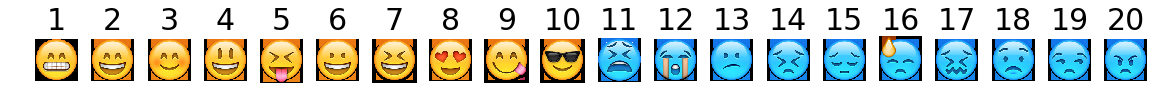

In [14]:
# Load data
reduced, images, labels = load_image(file_names)
reduced = reduced.reshape(reduced.shape[0], -1)

# Visualize Initial Emoji Indexing
num_samples = images.shape[0]
fig, axes = plt.subplots(1, num_samples)
for i in range(images.shape[0]):
    axes[i].axis('off')
    axes[i].set_title('{}'.format(i+1), fontdict={'fontsize':30})
    image = images[i].copy()
    if labels[i] == 1:
        image = image[...,::-1]
    axes[i].imshow(image)
plt.show()

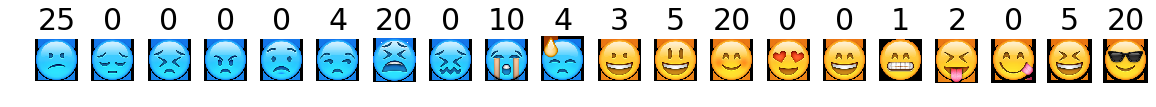

In [79]:
# change the weight 
weight = np.array([0,0,0,0,0,
                   0,0,0,0,0,
                   0,0,0,0,0,
                   0,0,0,0,0]).reshape((20,1))
# weight = np.array([0,2,0,2,0,
#                    0,0,2,4,3,
#                    4,2,0,0,1,
#                    1,0,1,3,0]).reshape((20,1))
p_manual = DualPerceptron_Manual(reduced, labels, weight)
preds, y_hat = p_manual.predict()
visualize_results(images, preds, labels, p_manual.alpha)
print(preds)

In [ ]:
# 